In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
import networkx as nx

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar,StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
g1 = nx.read_graphml("2019-12-31.graphml")
g2 = nx.read_graphml("2020-01-01.graphml")

In [3]:
G = nx.intersection(g1, g2)

In [4]:
subg1 = g1.subgraph(G.nodes())
subg2 = g2.subgraph(G.nodes())

In [5]:
subg1.number_of_nodes()

43417

In [6]:
subg2.number_of_nodes()

43417

In [7]:
nx.get_edge_attributes(subg1,'n_tx')

{('454614878', '435253493'): 1,
 ('379703244', '345480593'): 1,
 ('62129034', '23158888'): 14,
 ('62129034', '18435336'): 1,
 ('62129034', '340045788'): 1,
 ('62129034', '32318164'): 1,
 ('62129034', '28328448'): 1,
 ('62129034', '44607962'): 1,
 ('62129034', '20271054'): 1,
 ('62129034', '109745244'): 1,
 ('62129034', '45675459'): 1,
 ('62129034', '23671948'): 1,
 ('62129034', '22468950'): 1,
 ('62129034', '23582560'): 6,
 ('62129034', '43952585'): 4,
 ('62129034', '23672982'): 1,
 ('62129034', '23670763'): 1,
 ('62129034', '40012066'): 3,
 ('62129034', '14916779'): 1,
 ('62129034', '15459920'): 4,
 ('62129034', '332170119'): 1,
 ('62129034', '16747797'): 6,
 ('62129034', '52116564'): 2,
 ('62129034', '26506805'): 1,
 ('62129034', '16403130'): 1,
 ('62129034', '15898861'): 3,
 ('62129034', '16676156'): 1,
 ('62129034', '96780285'): 4,
 ('62129034', '32771821'): 1,
 ('62129034', '454581598'): 1,
 ('62129034', '837762'): 2,
 ('62129034', '20870509'): 2,
 ('62129034', '289943900'): 1,
 (

In [8]:
nx.set_edge_attributes(subg1, nx.get_edge_attributes(subg1, "n_tx"), name="weight")

In [9]:
nx.set_edge_attributes(subg2, nx.get_edge_attributes(subg2, "n_tx"), name="weight")

In [10]:
df_nodes1 = nx.to_pandas_adjacency(subg1)
df_nodes2 = nx.to_pandas_adjacency(subg2)

In [11]:
Gs1 = StellarGraph.from_networkx(
    subg1,node_features=df_nodes1
)
Gs2 = StellarGraph.from_networkx(
    subg2,node_features=df_nodes2
)

In [12]:
print(Gs1.info())

StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 35200

 Node types:
  default: [43417]
    Features: float32 vector, length 43417
    Edge types: default-default->default

 Edge types:
    default-default->default: [35200]
        Weights: range=[1, 2513], mean=2.42068, std=21.0797
        Features: none


In [13]:
print(Gs2.info())

StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 46496

 Node types:
  default: [43417]
    Features: float32 vector, length 43417
    Edge types: default-default->default

 Edge types:
    default-default->default: [46496]
        Weights: range=[1, 527], mean=1.70208, std=6.92294
        Features: none


In [14]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(Gs2)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False
)

** Sampled 4649 positive and 4649 negative edges. **


In [15]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(Gs1)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False
)

** Sampled 3520 positive and 3520 negative edges. **


In [16]:
batch_size = 20
epochs = 20
num_samples = [20, 10]

In [17]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [18]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [19]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [20]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

/Users/liminghao/miniconda3/envs/stellar/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [21]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [22]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [23]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2023-05-19 20:38:55.403101: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


465/465 [==============================] - 10045s 22s/step - loss: 4.0009 - acc: 0.5359

Train Set Metrics of the initial (untrained) model:
	loss: 4.1992
	acc: 0.5520

Test Set Metrics of the initial (untrained) model:
	loss: 4.0009
	acc: 0.5359


In [24]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
352/352 - 1586s - loss: 0.8338 - acc: 0.6142 - val_loss: 1.4095 - val_acc: 0.5871 - 1586s/epoch - 5s/step
Epoch 2/20
352/352 - 1523s - loss: 0.6560 - acc: 0.6893 - val_loss: 1.3898 - val_acc: 0.6068 - 1523s/epoch - 4s/step
Epoch 3/20
352/352 - 18540s - loss: 0.6352 - acc: 0.6909 - val_loss: 1.4243 - val_acc: 0.6050 - 18540s/epoch - 53s/step
Epoch 4/20
352/352 - 1677s - loss: 0.5774 - acc: 0.7210 - val_loss: 1.4254 - val_acc: 0.6134 - 1677s/epoch - 5s/step
Epoch 5/20
352/352 - 24886s - loss: 0.5609 - acc: 0.7298 - val_loss: 1.5097 - val_acc: 0.5901 - 24886s/epoch - 71s/step
Epoch 6/20
352/352 - 1432s - loss: 0.6236 - acc: 0.6936 - val_loss: 1.4324 - val_acc: 0.6264 - 1432s/epoch - 4s/step
Epoch 7/20
352/352 - 1476s - loss: 0.5706 - acc: 0.7254 - val_loss: 1.4525 - val_acc: 0.6198 - 1476s/epoch - 4s/step
Epoch 8/20
352/352 - 1474s - loss: 0.5380 - acc: 0.7405 - val_loss: 1.4443 - val_acc: 0.6238 - 1474s/epoch - 4s/step
Epoch 9/20
352/352 - 1619s - loss: 0.5262 - acc: 0.7520 - 

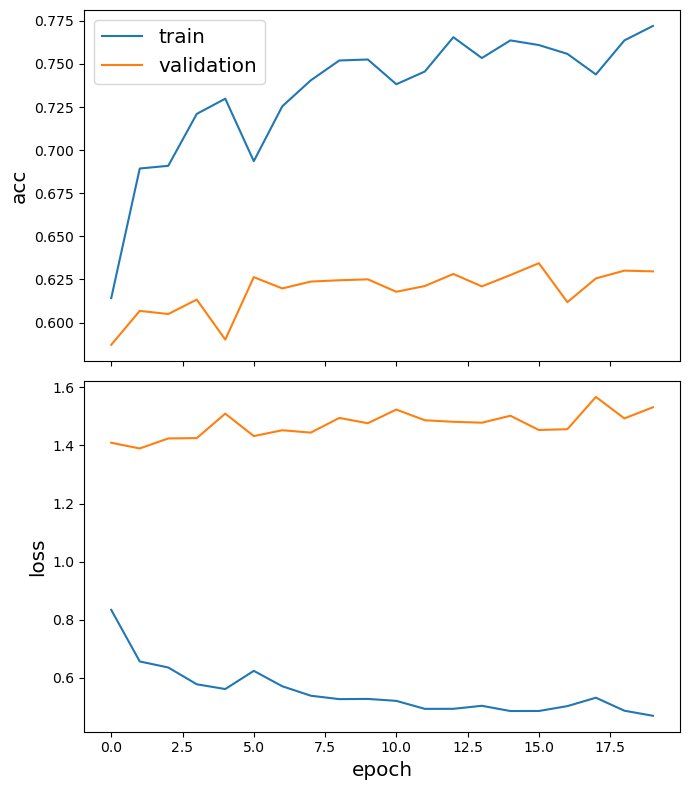

In [25]:
sg.utils.plot_history(history)

In [26]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

465/465 [==============================] - 2288s 5s/step - loss: 1.5427 - acc: 0.6282

Train Set Metrics of the trained model:
	loss: 2.5757
	acc: 0.6753

Test Set Metrics of the trained model:
	loss: 1.5427
	acc: 0.6282
